In [1]:
# Sorting events with m_HH_star > 350 GeV and m_HH_star < 350 GeV  

import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GATv2Conv, global_mean_pool
print('torch version:',torch.__version__)
print('torch version.cuda:',torch.version.cuda)
print('torch geometric version:',torch_geometric.__version__)
from sparticles_hadhad.rewritten_dataset import EventsDataset
from sparticles_hadhad.rewritten_dataset import DEFAULT_EVENT_SUBSETS
from sparticles_hadhad.rewritten_dataset import EVENT_TABLE
import matplotlib.pyplot as plt
from sparticles_hadhad.transforms import MakeHomogeneous
make_homogeneous_trans = MakeHomogeneous()
from sparticles import plot_event_2d
import os
import errno
import numpy as np
from numpy import pi
import time
from torchmetrics import Accuracy
from tqdm import tqdm # for nice bar
from sklearn.metrics import roc_curve, auc
import pandas as pd
from torch.utils.data import Subset
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
import json
import yaml

torch version: 2.2.1+cu121
torch version.cuda: 12.1
torch geometric version: 2.6.1


In [2]:
def remove_processed(filename):
    try:
        os.remove(filename)
    except OSError as e: 
        if e.errno != errno.ENOENT: 
            raise

MANUAL_SEED = 1234 

class GAT(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, num_classes):
        super(GAT, self).__init__()
        torch.manual_seed(MANUAL_SEED)
        self.conv1 = GATv2Conv(input_channels, hidden_channels)
        self.activation1 = torch.nn.ReLU() 
        self.conv2 = GATv2Conv(hidden_channels, hidden_channels)
        self.activation2 = torch.nn.ReLU() 
        self.conv3 = GATv2Conv(hidden_channels, hidden_channels)
        self.aggregate = global_mean_pool
        self.head = torch.nn.Linear(hidden_channels, num_classes)


    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.activation1(x)
        x = self.conv2(x, edge_index)
        x = self.activation2(x)
        x = self.conv3(x, edge_index)
        x = self.aggregate(x, batch)
        x = self.head(x)
        return x

def set_shift(all_graphs): 
    all_graphs = all_graphs[-1:] + all_graphs[:-1]
    return all_graphs

def import_snapshot(model, snap_name):
    checkpoint = torch.load(snap_name)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    val_losses = np.array(checkpoint['val_losses'])
    model.eval()

    return model, val_losses

def add_score_from_snapshot(dataset, model, snap_name):
    # Load snapshot and set model to that point
    checkpoint = torch.load(snap_name)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Loop over dataset and apply model
    new_data = []
    for elem in dataset:
        output = model(elem.data_norm.float(), elem.edge_index, elem.batch)
        prob = torch.sigmoid(output).squeeze().detach()
        # Make a new variable on the graph to add the score
        elem.score = prob
        new_data.append(elem)

    return new_data

class Weighter:

    def __init__(self, file_name):
        with open(file_name) as f:
            self.procDict = json.load(f)

    def scale(self, proc_name, lumi = 30, sample_frac = 1):
        # Lumi in ab-1

        lumi_ipb = lumi * 1e6     
        #eff_data = (self.events_data/self.procDict[proc_name]["numberOfEvents"])*0.03

        print('cross section:',self.procDict[proc_name]["crossSection"])
        print('kfactor:',self.procDict[proc_name]["kfactor"])
        print('matchingEfficiency:',self.procDict[proc_name]["matchingEfficiency"])
        print('numberOfEvents:',self.procDict[proc_name]["numberOfEvents"])
        return ((lumi_ipb * self.procDict[proc_name]["crossSection"] * 
                self.procDict[proc_name]["kfactor"] * 
                self.procDict[proc_name]["matchingEfficiency"]) / 
                (self.procDict[proc_name]["numberOfEvents"] * sample_frac))


In [62]:
#Code block for processing the raw data from the h5 file. These are the h5 files that cut events with pT < 20GeV.

LAMBDA_VAL = 100 #100, 240, 300
lambda_values = 100, 240, 300
lambda_signal = (72380, 74169, 65152)

if LAMBDA_VAL in lambda_values:
    index = lambda_values.index(LAMBDA_VAL)
    selected_signal = lambda_signal[index]

sig_no = selected_signal #max lambda100 = 72380, lambda240 = 74169, lambda300 = 65152
ttb_no = 213475 #max = 213475, inclusive max = 48444
vjets_no = 0

if sig_no == ttb_no:
    stats_string = 'balanced_stats'
else:
    stats_string = f'sig_{sig_no}_ttb_{ttb_no}'
    
processed_file = f"/hepstore/{os.environ['USER']}/fcc_hh_data_hadhad_84TeV/processed/events_signal_{sig_no}_ttbar_{ttb_no}_vjets_{vjets_no}.pt"

def remove_processed(filename):
    try:
        os.remove(filename)
    except OSError as e: 
        if e.errno != errno.ENOENT: 
            raise

remove_processed(processed_file)



# with open('means.yaml' ) as f:
#     mean_list_loaded = yaml.load(f, Loader = yaml.Loader)

# with open('std.yaml' ) as g:
#     std_list_loaded = yaml.load(g, Loader = yaml.Loader)


graphs = EventsDataset(
    root= f'/hepstore/{os.environ["USER"]}/fcc_hh_data_hadhad_84TeV',
    url='https://cernbox.cern.ch/s/SpsIy2kRzVZtwnn/download/',
    delete_raw_archive=False,
    add_edge_index=True,
    event_subsets={'signal': sig_no, 'ttbar': ttb_no, 'vjets': vjets_no}, #For the FCC, only ttbar events are used, but the h5 file for background is saved and taken from the 'singletop' file. 
    transform=MakeHomogeneous(),
    download_type=2,
    signal_filename=f'pwp8_pp_hh_lambda{LAMBDA_VAL}_5f_80TeV_SA_hhbbtata.h5', # Specify the signal filename here
    background_filename='mgp8_pp_tt012j_5f_84TeV_blvblv.h5',
    bb_features = {"m_bb": True, "dEta_bb": False, "dPhi_bb": False, "dR_bb": True},
    tt_features = {"m_tt": True, "dEta_tt": False, "dPhi_tt": False, "dR_tt": True, "dpT_tt": True},
    other_features = {"m_T": True, "C_met": True, "m_HH": True, "dPhi_HH": True},
#    loaded_means = mean_list_loaded, # for the standisation to be the same when applying the kappa_lambda = 1 to the other signal samples.
#    loaded_stds = std_list_loaded
)
  
save_bool = graphs.feature_string()

Processing...
Processing events in /hepstore/lwood/fcc_hh_data_hadhad_84TeV/raw/signal/pwp8_pp_hh_lambda100_5f_80TeV_SA_hhbb
Processing events in /hepstore/lwood/fcc_hh_data_hadhad_84TeV/raw/ttbar/mgp8_pp_tt012j_5f_84TeV_blvblv.h5: 100
Processing events in /hepstore/lwood/fcc_hh_data_hadhad_84TeV/raw/vjets/mgp8_pp_tt012j_5f_84TeV_blvblv.h5: 0it [00:00, ?it/s]
Done!


In [63]:
print(graphs[0].x.shape)

torch.Size([7, 24])


In [64]:
from torch.utils.data import Subset
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
import time

# 5 fold 
# fold |  A        | B        | C        | D        | E        |
#  1   |  Train    | Train    | Train    | Validate | Test     |
#  2   |  Test     | Train    | Train    | Train    | Validate |
#  3   |  Validate | Test     | Train    | Train    | Train    |
#  4   |  Train    | Validate | Test     | Train    | Train    |
#  4   |  Train    | Train    | Validate | Test     | Train    |


also_graphs = graphs

setA_graphs = also_graphs[0::5] 
setB_graphs = also_graphs[1::5] 
setC_graphs = also_graphs[2::5] 
setD_graphs = also_graphs[3::5]
setE_graphs = also_graphs[4::5]

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = GAT(input_channels=graphs[0].data_norm.shape[1], hidden_channels=50, num_classes=1) #num_classes denotes the output, we have output of dimension 1 in our case.
model.to(device)

def set_shift(all_graphs): 
    all_graphs = all_graphs[-1:] + all_graphs[:-1]
    return all_graphs


In [65]:
LEGEND_SIZE = 8
SMALL_SIZE = 12
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

Sorting by m_HH mass...
Done!
Reading Snapshot for Fold 0...
Done!
Plotting ROC Curve...


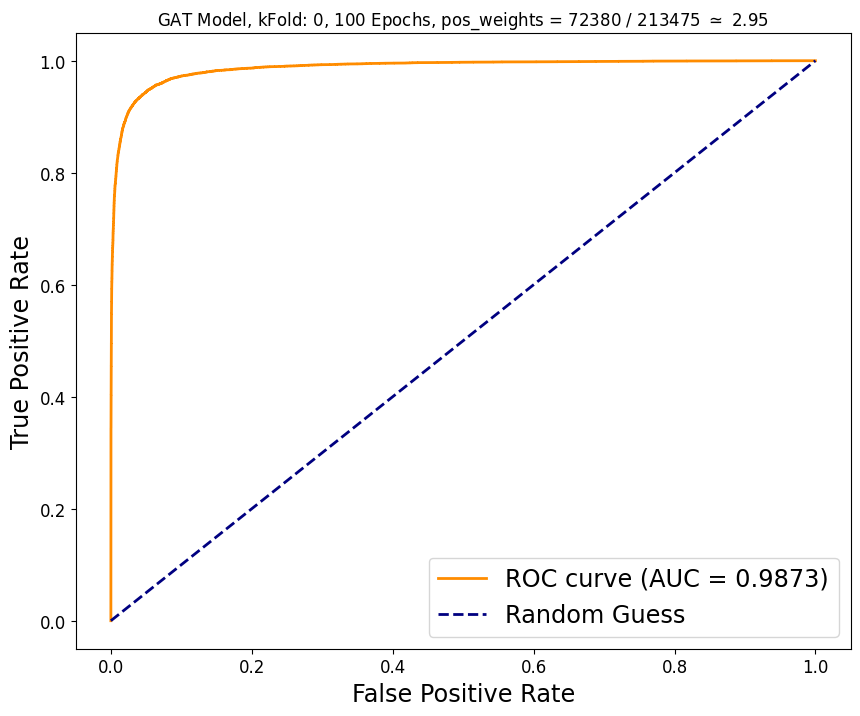

Plotting Score...


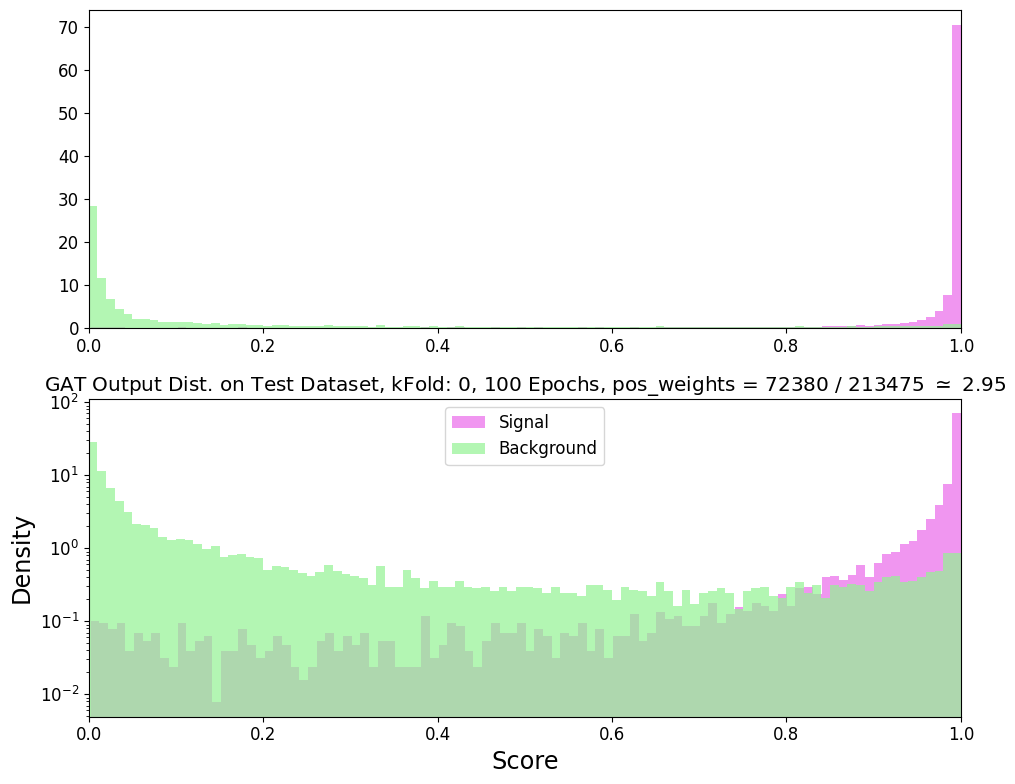

Sorting by m_HH mass...
Done!
Reading Snapshot for Fold 1...
Done!
Plotting ROC Curve...


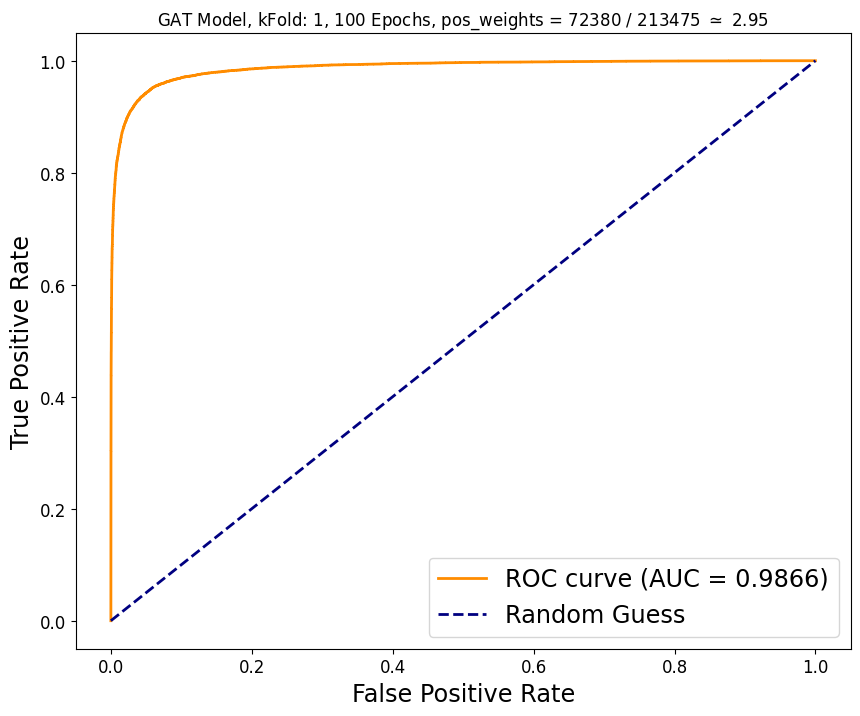

Plotting Score...


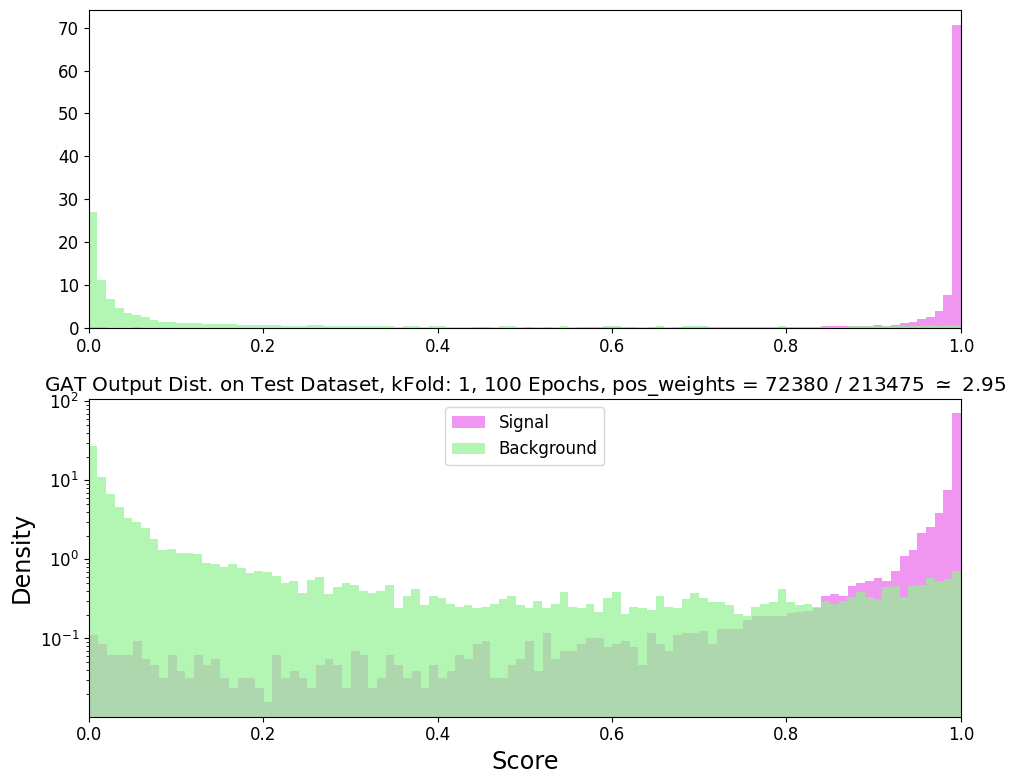

Sorting by m_HH mass...
Done!
Reading Snapshot for Fold 2...
Done!
Plotting ROC Curve...


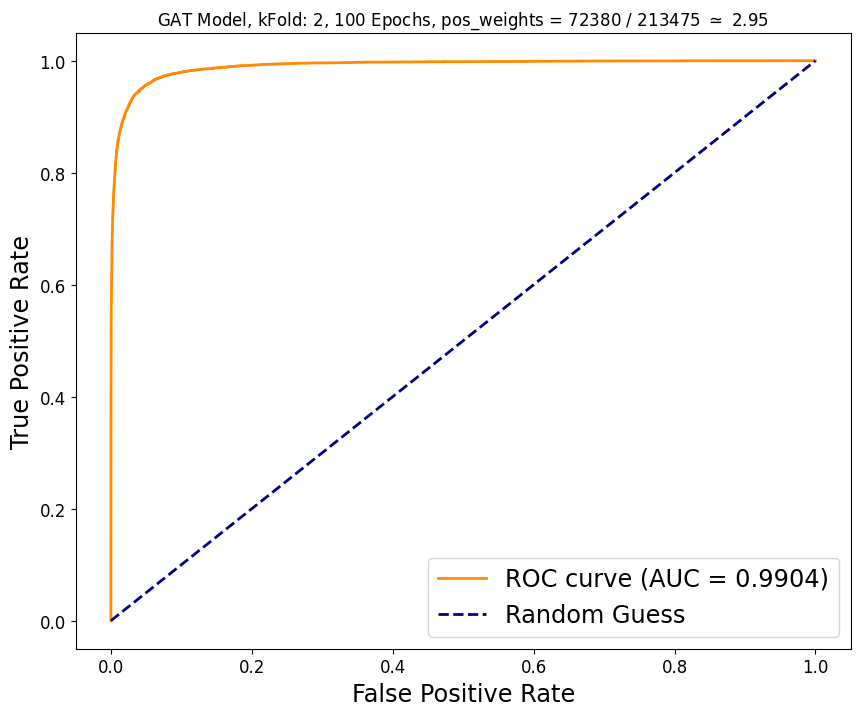

Plotting Score...


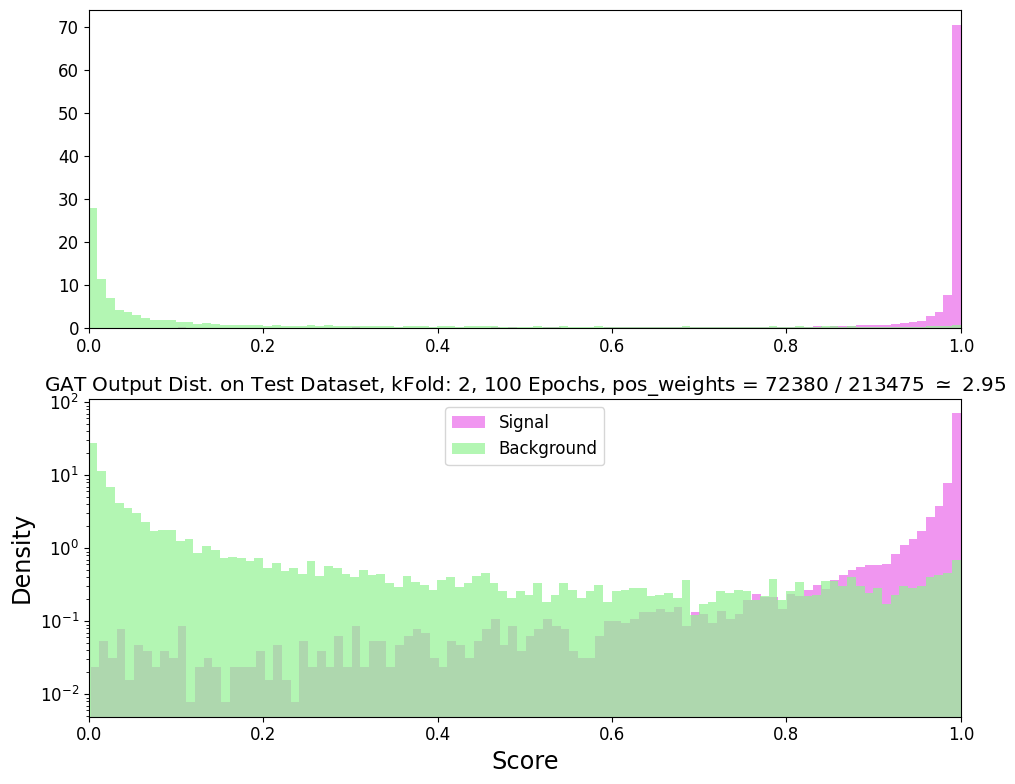

Sorting by m_HH mass...
Done!
Reading Snapshot for Fold 3...
Done!
Plotting ROC Curve...


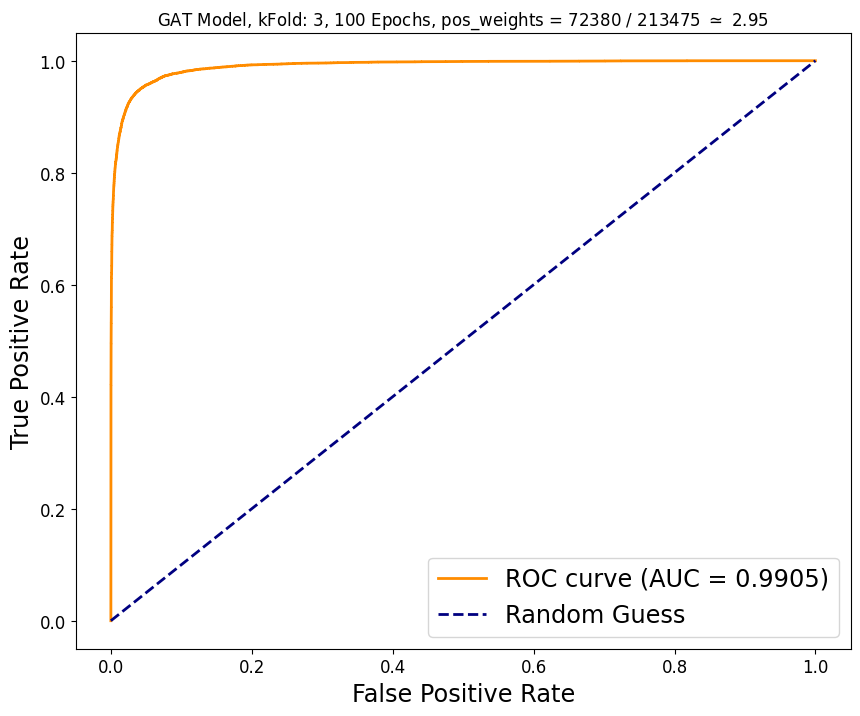

Plotting Score...


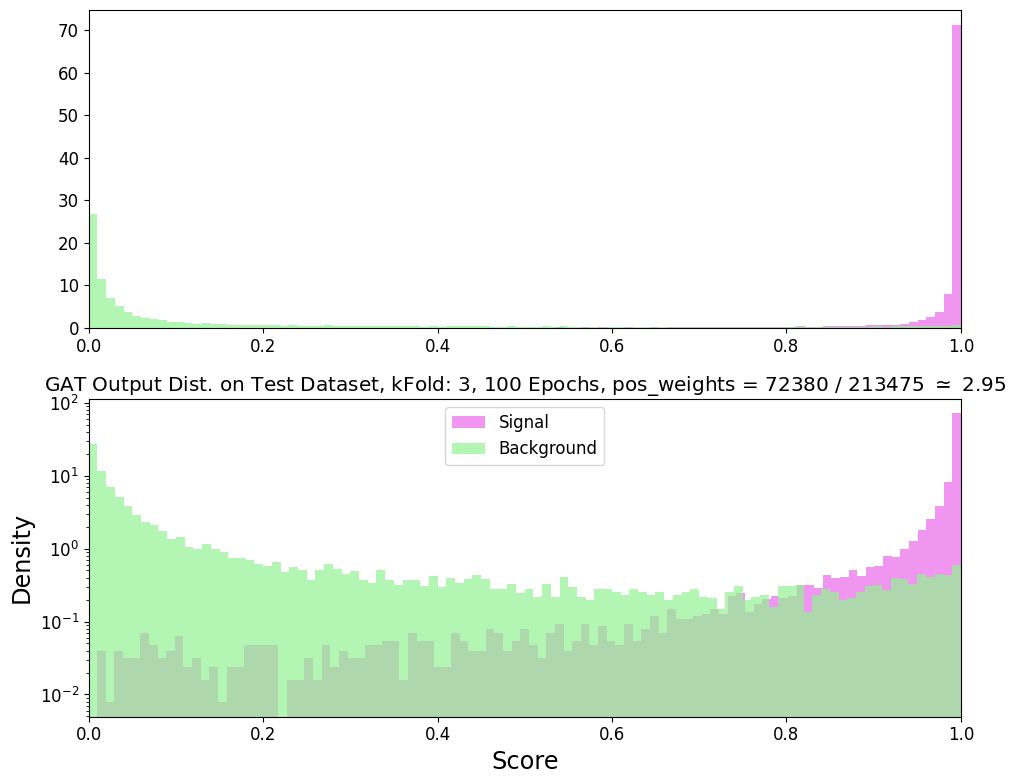

Sorting by m_HH mass...
Done!
Reading Snapshot for Fold 4...
Done!
Plotting ROC Curve...


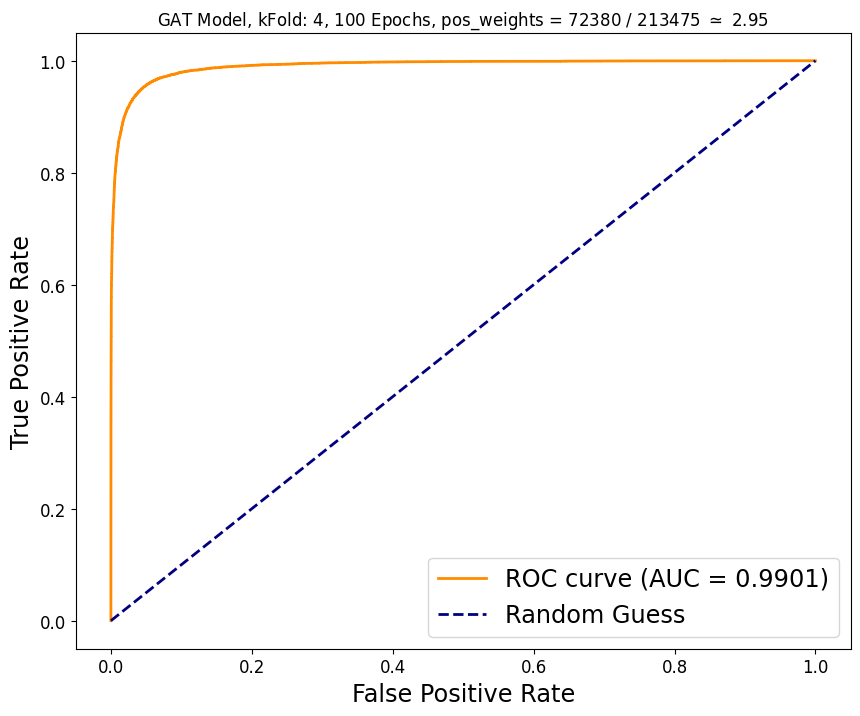

Plotting Score...


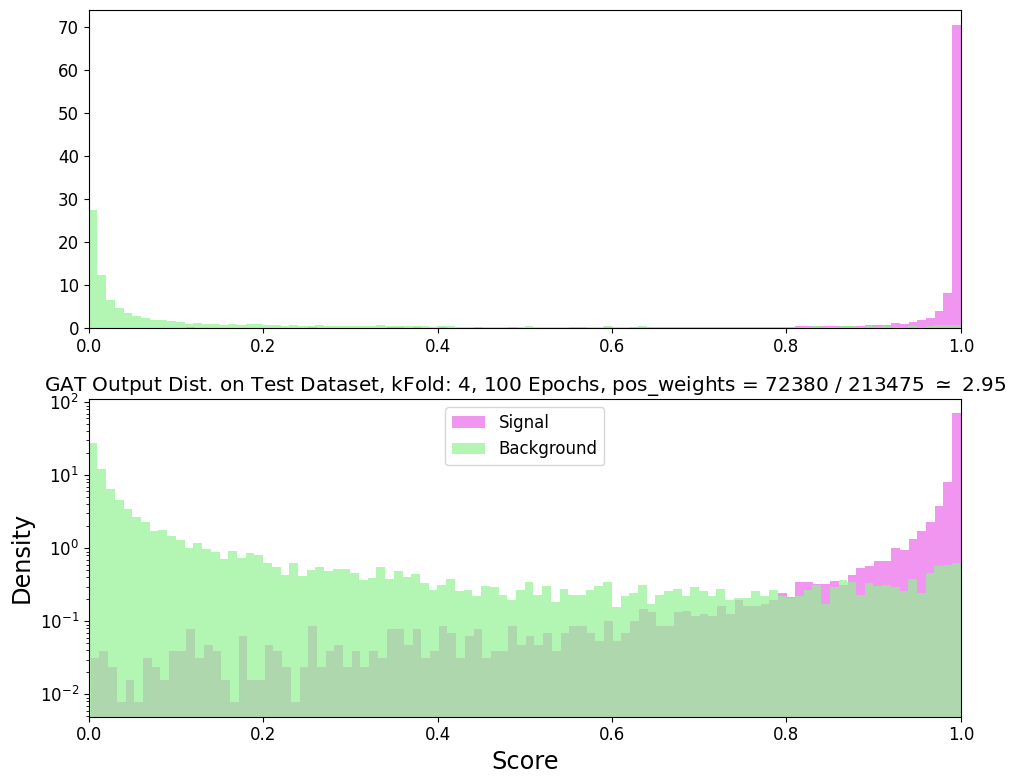

In [66]:
os.makedirs('Saved Figures/GATComplexNorm/kFold', exist_ok=True) 
sig_weight = ttb_no/sig_no
compute_acc = Accuracy(task='binary')
compute_acc.to(device)

test_losses = []
test_accuracies = []
all_true_labels = []
all_predicted_probs = []
all_signal_probs = []
all_background_probs = []
all_select_highmhh = []

LAST_EPOCH = 99
EPOCH_NUMBER = LAST_EPOCH + 1

m_HH_SELECTOR = True # True for > 350 GeV, False for < 350 GeV m_HH events.
if m_HH_SELECTOR:
    m_hh_string = 'high'
else:
    m_hh_string = 'low'

all_graphs = setA_graphs, setB_graphs, setC_graphs, setD_graphs, setE_graphs

for fold in range(len(all_graphs)):
    model.to(device)
    test_graphs = all_graphs[4] # selects the last value of all splits
    #print(test_graphs.x.shape)
    print('Sorting by m_HH mass...')
    if m_HH_SELECTOR:
        select_mhh =  [tg.x[-1][20] - tg.x[-1][6] - tg.x[-1][10] + 250 > 350 for tg in test_graphs]
    else:
        select_mhh =  [tg.x[-1][20] - tg.x[-1][6] - tg.x[-1][10] + 250 < 350 for tg in test_graphs]
    all_select_mhh = np.concatenate((all_select_highmhh, select_mhh))
    test_loader = DataLoader(test_graphs, batch_size=500, shuffle=False)
    print('Done!')
    #print(test_loader.dataset[0])
    print(f'Reading Snapshot for Fold {fold}...')
    model, _ = import_snapshot(model, f"Epochs/fixed_kFolds/CarlFold/84TeV/CarlFold_{fold}_100_epoch_{LAST_EPOCH}.pth")
    print('Done!')
    # ROC curve plotting
    print('Plotting ROC Curve...')
    model.cpu() # Move model to cpu
    # Concatenate true labels and predicted logits
    
    true_labels = torch.cat([batch.y for batch in test_loader.dataset]).numpy()
    all_true_labels = np.concatenate((all_true_labels, true_labels))
    predicted_logits = torch.cat([model(batch.data_norm.float(), batch.edge_index, batch.batch).detach().squeeze() for batch in test_loader]).numpy()
    # Convert logits to probabilities using sigmoid function
    predicted_probs = torch.sigmoid(torch.tensor(predicted_logits)).numpy()
    all_predicted_probs = np.concatenate((all_predicted_probs, predicted_probs))
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    
    plt.xlabel('False Positive Rate',fontsize="x-large")
    plt.ylabel('True Positive Rate',fontsize="x-large")
    plt.title(f'GAT Model, kFold: {fold}, {EPOCH_NUMBER} Epochs, pos_weights = {sig_no} / {ttb_no} $\simeq$ {sig_weight:.2f}')
    plt.legend(loc='lower right',fontsize="x-large")
    plt.savefig(f'Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV/RoCCurve_mHHTest_GAT_{save_bool}norm_{stats_string}_{EPOCH_NUMBER}epochs_kFold{fold}.png')
    plt.savefig(f'Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV/RoCCurve_mHHTest_GAT_{save_bool}norm_{stats_string}_{EPOCH_NUMBER}epochs_kFold{fold}.pdf')
    plt.show()
    # Score distribution plotting
    # Filter predictions based on true labels (signal and background)
    print('Plotting Score...')
    signal_indices = true_labels == 1
    background_indices = true_labels == 0

    
    signal_probs = predicted_probs[signal_indices & select_mhh]
    all_signal_probs = np.concatenate((all_signal_probs, signal_probs))
    background_probs = predicted_probs[background_indices & select_mhh]
    all_background_probs = np.concatenate((all_background_probs, background_probs))

    # torch.cat([batch.y for batch in test_loader.dataset]).numpy()
   
    
    # Plotting
    plt.figure(figsize=(10, 8))
    plt.subplot(2,1,1)
    plt.yscale('linear')
    plt.hist(signal_probs, bins=100, alpha=0.7, label='Signal', density=True, color='#ea6aea')
    plt.hist(background_probs, bins=100, alpha=0.7, label='Background', density=True, color='#93f393')
    plt.xlim(0,1)
    plt.subplot(2,1,2)
    plt.yscale('log')
    plt.hist(signal_probs, bins=100, color='#ea6aea', alpha=0.7, label='Signal', density=True)
    plt.hist(background_probs, bins=100, color='#93f393', alpha=0.7, label='Background', density=True)
    
    plt.title(f'GAT Output Dist. on Test Dataset, kFold: {fold}, {EPOCH_NUMBER} Epochs, pos_weights = {sig_no} / {ttb_no} $\simeq$ {sig_weight:.2f}',fontsize="large")
    plt.xlabel('Score',fontsize="x-large")
    plt.ylabel('Density',fontsize="x-large")
    plt.xlim(0,1)
    plt.legend()
    plt.tight_layout()
    #plt.savefig('ModelOutputDistDefault.png')
    plt.savefig(f'Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV/ModelOutputDist_{LAMBDA_VAL}_mHH_{m_hh_string}_GAT_{save_bool}norm_{stats_string}_{EPOCH_NUMBER}epochs_kFold{fold}.png')
    plt.savefig(f'Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV/ModelOutputDist_{LAMBDA_VAL}_mHH_{m_hh_string}_GAT_{save_bool}norm_{stats_string}_{EPOCH_NUMBER}epochs_kFold{fold}.pdf')
    plt.show()   
    all_graphs = set_shift(all_graphs) #shifts the slices by one

Plotting Combined kFold ROC Curve...


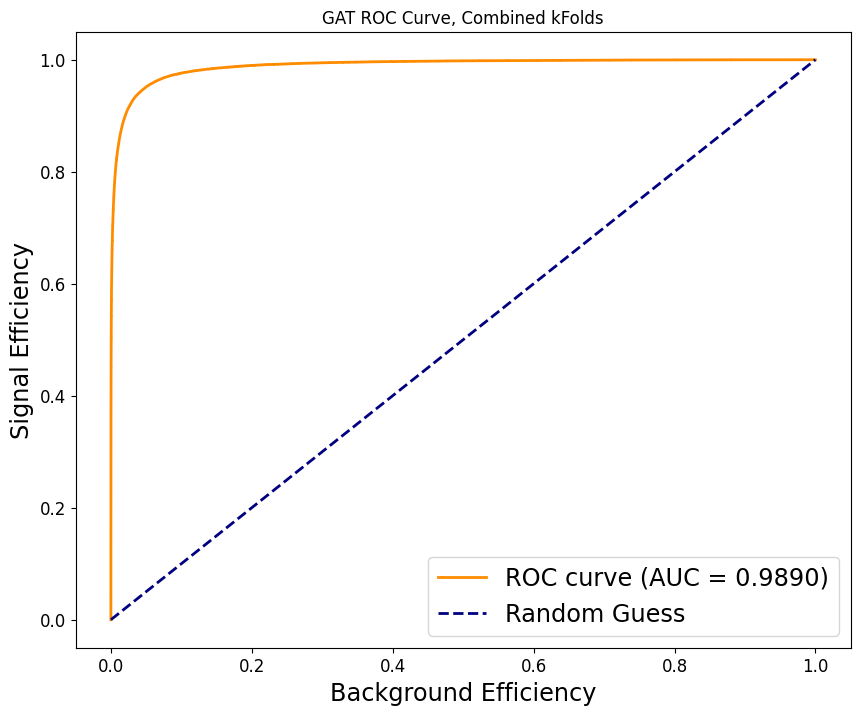

Plotting Combined kFold Score...


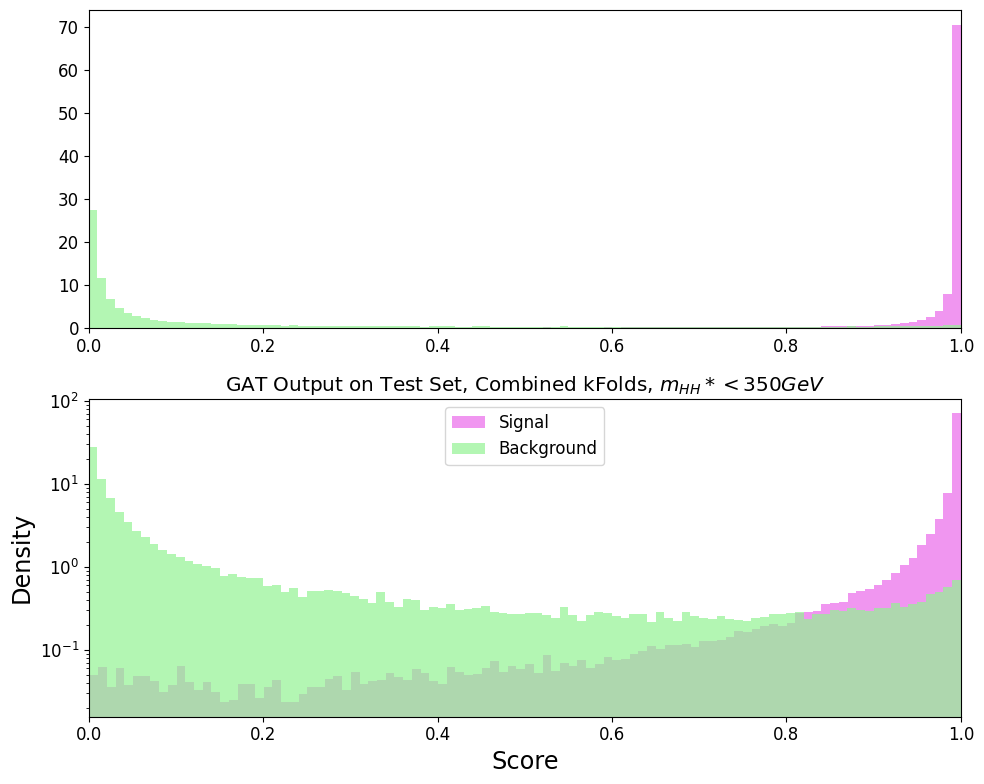

In [67]:
# Combined kfolds
print("Plotting Combined kFold ROC Curve...")
# ROC Curve Plotting
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_true_labels, all_predicted_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlabel('Background Efficiency',fontsize="x-large")
plt.ylabel('Signal Efficiency',fontsize="x-large")
plt.title(f'GAT ROC Curve, Combined kFolds')
plt.legend(loc='lower right',fontsize="x-large")
plt.savefig(f'Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV/RoCCurve_{LAMBDA_VAL}_mHH_{m_hh_string}_GAT_{save_bool}norm_{stats_string}_{EPOCH_NUMBER}epochs_kFold_TOTAL.png')
plt.savefig(f'Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV/RoCCurve_{LAMBDA_VAL}_mHH_{m_hh_string}_GAT_{save_bool}norm_{stats_string}_{EPOCH_NUMBER}epochs_kFold_TOTAL.pdf')
plt.show()

# Score Plotting
print("Plotting Combined kFold Score...")

# Plotting
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.yscale('linear')
plt.hist(all_signal_probs, bins=100, alpha=0.7, label='Signal', density=True, color='#ea6aea')
plt.hist(all_background_probs, bins=100, alpha=0.7, label='Background', density=True, color='#93f393')
plt.xlim(0,1)
plt.subplot(2,1,2)
plt.yscale('log')
plt.hist(all_signal_probs, bins=100, color='#ea6aea', alpha=0.7, label='Signal', density=True)
plt.hist(all_background_probs, bins=100, color='#93f393', alpha=0.7, label='Background', density=True)

plt.title('GAT Output on Test Set, Combined kFolds, $m_{HH}* < 350 GeV $',fontsize="large")
plt.xlabel('Score',fontsize="x-large")
plt.ylabel('Density',fontsize="x-large")
plt.xlim(0,1)
plt.legend()
plt.tight_layout()
#plt.savefig('ModelOutputDistDefault.png')
plt.savefig(f'Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV/ModelOutputDist_{LAMBDA_VAL}_mHH_{m_hh_string}_GAT_{save_bool}norm_{stats_string}_{EPOCH_NUMBER}epochs_kFold_TOTAL.png')
plt.savefig(f'Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV/ModelOutputDist_{LAMBDA_VAL}_mHH_{m_hh_string}_GAT_{save_bool}norm_{stats_string}_{EPOCH_NUMBER}epochs_kFold_TOTAL.pdf')
plt.show()   

In [12]:
# Cross sections seem to be in pb
#fname = "/cvmfs/fcc.cern.ch/FCCDicts/FCChh_procDict_fcc_v04.json"
#fname = "/hepstore/msullivan/FCC/FCCDicts/FCC_procDict_fcc_v04.json"
fname = "/user/jdegens/FCChh_procDict_fcc_v07_II.json"
weighter = Weighter(fname)

signal_correction_factor = 1
ttbar_correction_factor = 1

scale_signal = weighter.scale(f"pwp8_pp_hh_lambda300_5f_80TeV_SA_hhbbtata") * signal_correction_factor
print("HH -> bbtautau scale:", scale_signal)
#sig_scale =  [scale_signal] * len(all_signal_probs) 
print('')
scale_background = weighter.scale("mgp8_pp_tt012j_5f_84TeV_blvblv") * ttbar_correction_factor
print("ttbar scale:", scale_background)
# ttb_scale = ttb_no*scale/0.2
# print("Scaled ttbar:", ttb_scale)
#ttb_scale = [scale_background] * len(all_background_probs) 

cross section: 0.03104272395
kfactor: 1.075363
matchingEfficiency: 1.0
numberOfEvents: 1200000
HH -> bbtautau scale: 0.8345549188760963

cross section: 3509.405015568872
kfactor: 1.0
matchingEfficiency: 0.535
numberOfEvents: 72462609
ttbar scale: 777.3105506024549


In [59]:
import pandas as pd
import os 

bin_str = '>0.9', '>0.99', '>0.995', '>0.996', '>0.997', '>0.998', '>0.999'

# > 0.9
#bins=np.histogram(np.hstack((all_signal_probs ,all_background_probs)), bins=10)[1] #get the bin edges
bins = np.linspace(0,1,11)
sig_col_1 = [plt.hist(all_signal_probs, bins=bins, alpha=0.7, label='Signal', color='#ea6aea')[0][9]]
bkg_col_1 = [plt.hist(all_background_probs, bins=bins, alpha=0.7, label='Background', color='#93f393')[0][9]]
#bin_col_1 = [np.round(np.linspace(0.1,0.9,9), decimals=1)]

# > 0.99
#bins=np.histogram(np.hstack((all_signal_probs ,all_background_probs)), bins=100)[1] #get the bin edges
bins = np.linspace(0,1,101)
sig_col_01 = [plt.hist(all_signal_probs, bins=bins, alpha=0.7, label='Signal', color='#ea6aea')[0][99]]
bkg_col_01 = [plt.hist(all_background_probs, bins=bins, alpha=0.7, label='Background', color='#93f393')[0][99]]
#bin_col_01 = [np.round(np.linspace(0.91,0.99,9), decimals=2)]

# > 0.995 to > 0.999
#bins=np.histogram(np.hstack((all_signal_probs ,all_background_probs)), bins=1000)[1] #get the bin edges
bins = np.linspace(0,1,1001)
sig_col_001 = plt.hist(all_signal_probs, bins=bins, alpha=0.7, label='Signal', color='#ea6aea')[0][995:]
bkg_col_001 = plt.hist(all_background_probs, bins=bins, alpha=0.7, label='Background', color='#93f393')[0][995:]

# 0.001 to 1.000
bins = np.linspace(0,1,10001)
sig_col_full = plt.hist(all_signal_probs, bins=bins, alpha=0.7, label='Signal', color='#ea6aea')[0]
bkg_col_full = plt.hist(all_background_probs, bins=bins, alpha=0.7, label='Background', color='#93f393')[0]

#reversing the array...
sig_col_001 = sig_col_001[::-1]
bkg_col_001 = bkg_col_001[::-1]

sum_sig_col_001 = []
sum_bkg_col_001 = []
for val in range(len(sig_col_001)): #summating values
    sum_sig_col_001.append(sum(sig_col_001[0:val+1]))
    sum_bkg_col_001.append(sum(bkg_col_001[0:val+1]))

# unreversing
sum_sig_col_001 = [sum_sig_col_001[::-1]]
sum_bkg_col_001 = [sum_bkg_col_001[::-1]]

#bin_col_001 = [np.round(np.linspace(0.995,0.998,4), decimals=3)]

# Collecting columns

#bin_col = np.append(np.append(bin_col_1, bin_col_01), bin_col_001)
bin_col = bin_str
sig_col = np.append(np.append(sig_col_1, sig_col_01), sum_sig_col_001)
bkg_col = np.append(np.append(bkg_col_1, bkg_col_01), sum_bkg_col_001)

d = {'bin': bin_col, 'signal': sig_col, 'ttbar': bkg_col}
df = pd.DataFrame(data=d)
print('Unscaled Values:')
print(df) 

os.makedirs('CSVs/kFolds', exist_ok=True)  

df.to_csv(f'CSVs/kFolds/CarlFold/84TeV/OutputHist_{LAMBDA_VAL}_mHH_{m_hh_string}_GAT_{save_bool}norm_{stats_string}_{EPOCH_NUMBER}epochs.csv', index=False) 
plt.close()

# scaled values

# > 0.9
#bins=np.histogram(np.hstack((all_signal_probs ,all_background_probs)), bins=10)[1] #get the bin edges
bins = np.linspace(0,1,11)
sig_col_1 = [plt.hist(all_signal_probs, bins=bins, alpha=0.7, label='Signal', color='#ea6aea', weights=sig_scale)[0][9]]
bkg_col_1 = [plt.hist(all_background_probs, bins=bins, alpha=0.7, label='Background', color='#93f393', weights=ttb_scale)[0][9]]
#bin_col_1 = [np.round(np.linspace(0.1,0.9,9), decimals=1)]

# > 0.99
#bins=np.histogram(np.hstack((all_signal_probs ,all_background_probs)), bins=100)[1] #get the bin edges
bins = np.linspace(0,1,101)
sig_col_01 = [plt.hist(all_signal_probs, bins=bins, alpha=0.7, label='Signal', color='#ea6aea', weights=sig_scale)[0][99]]
bkg_col_01 = [plt.hist(all_background_probs, bins=bins, alpha=0.7, label='Background', color='#93f393', weights=ttb_scale)[0][99]]
#bin_col_01 = [np.round(np.linspace(0.91,0.99,9), decimals=2)]

# > 0.995 to > 0.999
#bins=np.histogram(np.hstack((all_signal_probs ,all_background_probs)), bins=1000)[1] #get the bin edges
bins = np.linspace(0,1,1001)
sig_col_001 = plt.hist(all_signal_probs, bins=bins, alpha=0.7, label='Signal', color='#ea6aea', weights=sig_scale)[0][995:]
bkg_col_001 = plt.hist(all_background_probs, bins=bins, alpha=0.7, label='Background', color='#93f393', weights=ttb_scale)[0][995:]

# 0.0001 to 1.0000
bins = np.linspace(0,1,10001)
sig_col_full_scaled = plt.hist(all_signal_probs, bins=bins, alpha=0.7, label='Signal', color='#ea6aea', weights=sig_scale)[0]
bkg_col_full_scaled = plt.hist(all_background_probs, bins=bins, alpha=0.7, label='Background', color='#93f393', weights=ttb_scale)[0]

#revising the array...
sig_col_001 = sig_col_001[::-1]
bkg_col_001 = bkg_col_001[::-1]

sum_sig_col_001 = []
sum_bkg_col_001 = []
for val in range(len(sig_col_001)): #summating values
    sum_sig_col_001.append(sum(sig_col_001[0:val+1]))
    sum_bkg_col_001.append(sum(bkg_col_001[0:val+1]))

# unreversing
sum_sig_col_001 = [sum_sig_col_001[::-1]]
sum_bkg_col_001 = [sum_bkg_col_001[::-1]]

#bin_col_001 = [np.round(np.linspace(0.995,0.998,4), decimals=3)]

# Collecting columns

#bin_col = np.append(np.append(bin_col_1, bin_col_01), bin_col_001)
bin_col = bin_str
sig_col = np.append(np.append(sig_col_1, sig_col_01), sum_sig_col_001)
bkg_col = np.append(np.append(bkg_col_1, bkg_col_01), sum_bkg_col_001)

print('')
print('Scaled Values:')
d = {'bin': bin_col, 'signal': sig_col, 'ttbar': bkg_col}
df = pd.DataFrame(data=d)
print(df) 
plt.close()
df.to_csv(f'CSVs/kFolds/CarlFold/84TeV/Scaled_combined_OutputHist_{LAMBDA_VAL}_mHH_{m_hh_string}_GAT_{save_bool}norm_{stats_string}_{EPOCH_NUMBER}epochs.csv', index=False)

bin_col_full = np.round(np.linspace(0,0.9999,10000), 4)
d = {'bin': bin_col_full, 'signal': sig_col_full, 'signal (scaled)': sig_col_full_scaled, 'ttbar': bkg_col_full, 'ttbar (scaled)': bkg_col_full_scaled}
df_full = pd.DataFrame(data=d)
df_full.to_csv(f'CSVs/kFolds/CarlFold/84TeV/FULL_combined_OutputHist_{LAMBDA_VAL}_mHH_{m_hh_string}_{stats_string}.csv', index=False)

Unscaled Values:
      bin   signal   ttbar
0    >0.9  60519.0  1580.0
1   >0.99  48821.0   229.0
2  >0.995  43481.0   123.0
3  >0.996  41634.0   101.0
4  >0.997  39169.0    76.0
5  >0.998  35396.0    55.0
6  >0.999  28508.0    27.0

Scaled Values:
      bin        signal         ttbar
0    >0.9  50506.429135  1.228151e+06
1   >0.99  40743.805694  1.780041e+05
2  >0.995  36287.282428  9.560920e+04
3  >0.996  34745.859492  7.850837e+04
4  >0.997  32688.681617  5.907560e+04
5  >0.998  29539.905908  4.275208e+04
6  >0.999  23791.491627  2.098738e+04


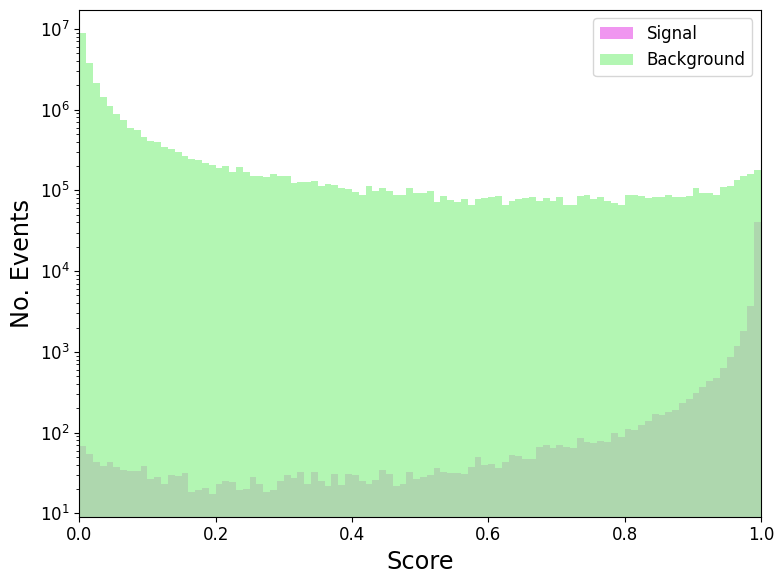

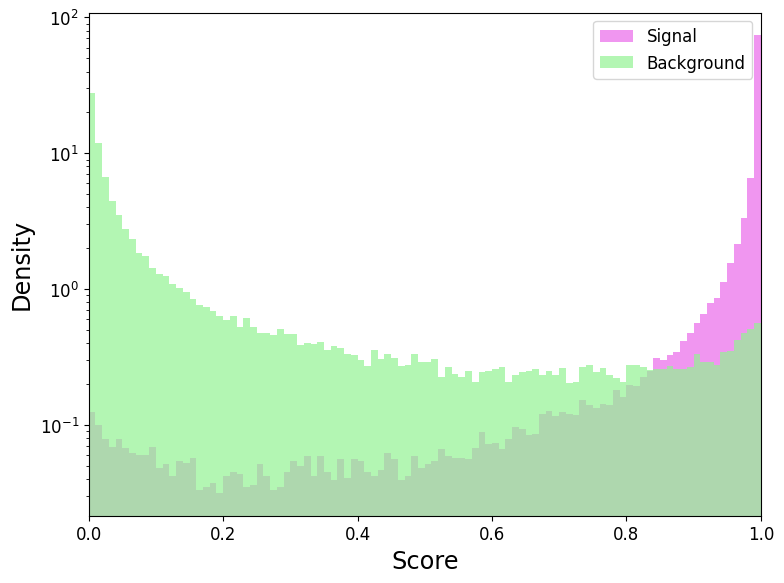

In [60]:
# Scaled Score Plot

plt.figure(figsize=(8, 6))
plt.yscale('log')
#bins=np.histogram(np.hstack((all_signal_probs ,all_background_probs)), bins=1000)[1] #get the bin edges
bins = np.linspace(0,1,101)
plt.hist(all_signal_probs, bins=bins, color='#ea6aea', alpha=0.7, label='Signal', weights=sig_scale)
plt.hist(all_background_probs, bins=bins, color='#93f393', alpha=0.7, label='Background', weights=ttb_scale)

plt.xlabel('Score',fontsize="x-large")
plt.ylabel('No. Events',fontsize="x-large")
plt.xlim(0,1)
plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('ModelOutputDistDefault.png')
plt.savefig(f'Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV/hadhad_{LAMBDA_VAL}_mHH_{m_hh_string}_Score_CarlFold_scaled.png')
plt.savefig(f'Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV/hadhad_{LAMBDA_VAL}_mHH_{m_hh_string}_Score_CarlFold_scaled.pdf')
plt.show()

plt.figure(figsize=(8, 6))
plt.yscale('log')
#bins=np.histogram(np.hstack((all_signal_probs ,all_background_probs)), bins=1000)[1] #get the bin edges
bins = np.linspace(0,1,101)
plt.hist(all_signal_probs, bins=bins, color='#ea6aea', alpha=0.7, label='Signal', weights=sig_scale, density=True)
plt.hist(all_background_probs, bins=bins, color='#93f393', alpha=0.7, label='Background', weights=ttb_scale, density=True)

plt.xlabel('Score',fontsize="x-large")
plt.ylabel('Density',fontsize="x-large")
plt.xlim(0,1)
plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('ModelOutputDistDefault.png')
plt.savefig(f'Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV/hadhad_{LAMBDA_VAL}_mHH_{m_hh_string}_Score_CarlFold_scaled_density.png')
plt.savefig(f'Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV/hadhad_{LAMBDA_VAL}_mHH_{m_hh_string}_Score_CarlFold_scaled_density.pdf')
plt.show()

66252 40939


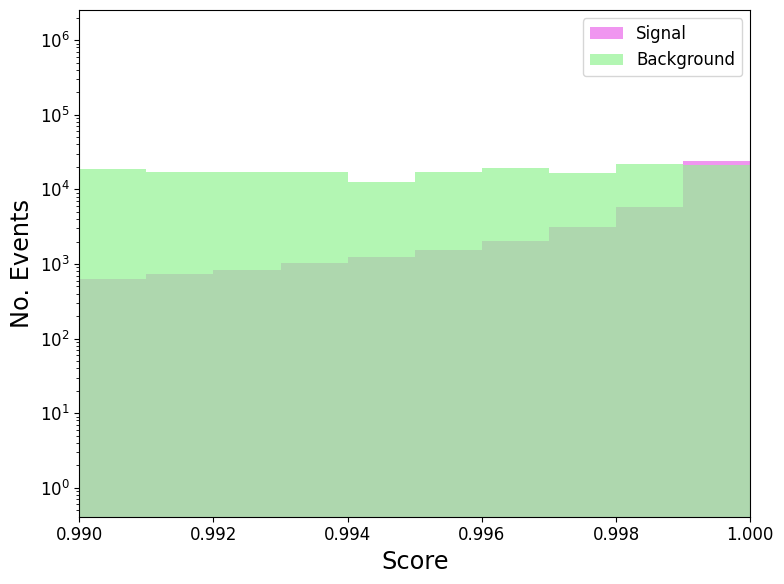

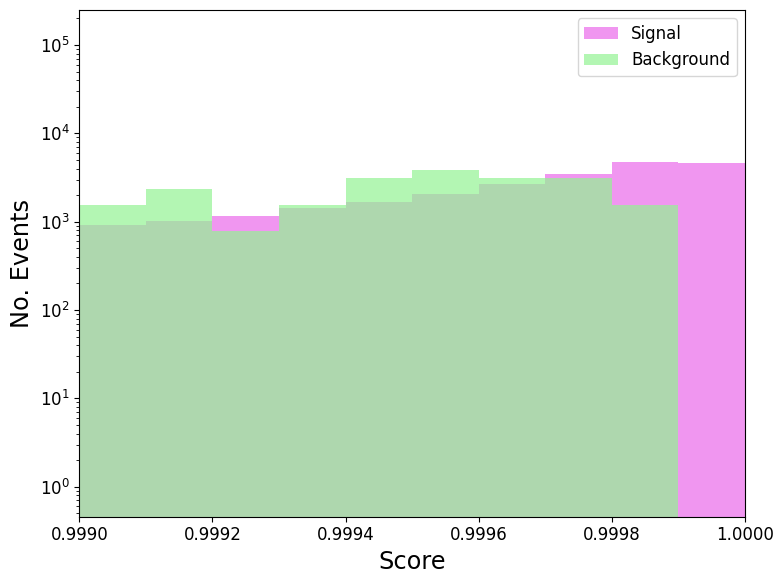

In [61]:
# Plotting

print(len(all_signal_probs), len(all_background_probs))

plt.figure(figsize=(8, 6))
plt.yscale('log')
#bins=np.histogram(np.hstack((all_signal_probs ,all_background_probs)), bins=1000)[1] #get the bin edges
bins = np.linspace(0,1,1001)
plt.hist(all_signal_probs, bins=bins, color='#ea6aea', alpha=0.7, label='Signal', weights=sig_scale)
plt.hist(all_background_probs, bins=bins, color='#93f393', alpha=0.7, label='Background', weights=ttb_scale)

plt.xlabel('Score',fontsize="x-large")
plt.ylabel('No. Events',fontsize="x-large")
plt.xlim(0.99,1)
plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('ModelOutputDistDefault.png')
plt.savefig(f'Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV/hadhad_{LAMBDA_VAL}_mHH_{m_hh_string}_Score_CarlFold_scaled_zoom0.99.png')
plt.savefig(f'Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV/hadhad_{LAMBDA_VAL}_mHH_{m_hh_string}_Score_CarlFold_scaled_zoom0.99.pdf')
plt.show()


plt.figure(figsize=(8, 6))
plt.yscale('log')
#bins=np.histogram(np.hstack((all_signal_probs ,all_background_probs)), bins=1000)[1] #get the bin edges
bins = np.linspace(0,1,10001)
plt.hist(all_signal_probs, bins=bins, color='#ea6aea', alpha=0.7, label='Signal', weights=sig_scale)
plt.hist(all_background_probs, bins=bins, color='#93f393', alpha=0.7, label='Background', weights=ttb_scale)

plt.xlabel('Score',fontsize="x-large")
plt.ylabel('No. Events',fontsize="x-large")
plt.xlim(0.999,1)
plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('ModelOutputDistDefault.png')
plt.savefig(f'Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV/hadhad_{LAMBDA_VAL}_mHH_{m_hh_string}_Score_CarlFold_scaled_zoom0.999.png')
plt.savefig(f'Saved Figures/GATComplexNorm/kFold/CarlFold/84TeV/hadhad_{LAMBDA_VAL}_mHH_{m_hh_string}_Score_CarlFold_scaled_zoom0.999.pdf')
plt.show()

# print('Signal bins (0.99-1.00) = ',plt.hist(all_signal_probs, bins=bins, alpha=0.7, label='Signal', color='#ea6aea', weights=sig_scale)[0][989:])
# print('')
# print('Background bins (0.99-1.00) = ',plt.hist(all_background_probs, bins=bins, alpha=0.7, label='Background', color='#93f393', weights=ttb_scale)[0][989:])
# plt.close()